Step 1: Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

Step 2: Loading and Analyzing the data

In [7]:
data = pd.read_csv("fake_or_real_news.csv")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [9]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [10]:
data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [11]:
data['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

In [12]:
x = data['text']
y= data ['label']

In [13]:
x_train , x_test, y_train, y_test = train_test_split(x,y,train_size = 0.7)

In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df = 0.7)

In [15]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

In [16]:
print("Shape of TF-IDF train data:", tfidf_train.shape)
print("Shape of TF-IDF test data:", tfidf_test.shape)

Shape of TF-IDF train data: (4434, 58668)
Shape of TF-IDF test data: (1901, 58668)


In [17]:
X_train_tokens = [text.split() for text in x_train]
X_test_tokens = [text.split() for text in x_test]

In [18]:
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(X_train_tokens, total_examples=len(X_train_tokens), epochs=10)


(28051155, 34425920)

In [19]:
# Create average Word2Vec embeddings
def get_w2v_embeddings(text_tokens, model, vector_size):
    embeddings = np.zeros((len(text_tokens), vector_size))
    for i, tokens in enumerate(text_tokens):
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            embeddings[i] = np.mean(model.wv[valid_tokens], axis=0)
    return embeddings

w2v_train = get_w2v_embeddings(X_train_tokens, w2v_model, 100)
w2v_test = get_w2v_embeddings(X_test_tokens, w2v_model, 100)


In [20]:
# Standardize Word2Vec embeddings
scaler = StandardScaler()
w2v_train = scaler.fit_transform(w2v_train)
w2v_test = scaler.transform(w2v_test)

Step 4: Model Training and Evaluation

For TF-IDF 

In [21]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier()
}

In [22]:
# Train and evaluate models with TF-IDF features
tfidf_results = {}
for name, model in models.items():
    model.fit(tfidf_train, y_train)
    preds = model.predict(tfidf_test)
    probs = model.predict_proba(tfidf_test)[:, 1]
    
    # Evaluation
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, pos_label='FAKE')
    recall = recall_score(y_test, preds, pos_label='FAKE')
    f1 = f1_score(y_test, preds, pos_label='FAKE')
    roc_auc = roc_auc_score(y_test, probs)
    
    tfidf_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    
    # Print results
    print(f"Results for {name} (TF-IDF):")
    print(tfidf_results[name])
    print()

Results for Logistic Regression (TF-IDF):
{'Accuracy': 0.9184639663335087, 'Precision': 0.8901209677419355, 'Recall': 0.9504843918191603, 'F1 Score': 0.9193128578865174, 'ROC AUC': 0.976507993461707}

Results for Naive Bayes (TF-IDF):
{'Accuracy': 0.8521830615465544, 'Precision': 0.9709302325581395, 'Recall': 0.7190527448869752, 'F1 Score': 0.8262213976499692, 'ROC AUC': 0.9636850102105454}

Results for SVM (TF-IDF):
{'Accuracy': 0.9384534455549711, 'Precision': 0.921161825726141, 'Recall': 0.9558665231431647, 'F1 Score': 0.9381933438985738, 'ROC AUC': 0.9837904822655451}

Results for Random Forest (TF-IDF):
{'Accuracy': 0.9153077327722251, 'Precision': 0.9192139737991266, 'Recall': 0.9063509149623251, 'F1 Score': 0.9127371273712737, 'ROC AUC': 0.9666922484019721}



For Word2Vec Features:

In [23]:
# Initialize models
w2v_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier()
}

# Train and evaluate models with Word2Vec features
w2v_results = {}
for name, model in w2v_models.items():
    model.fit(w2v_train, y_train)
    preds = model.predict(w2v_test)
    probs = model.predict_proba(w2v_test)[:, 1]
    
    # Evaluation
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, pos_label='FAKE')
    recall = recall_score(y_test, preds, pos_label='FAKE')
    f1 = f1_score(y_test, preds, pos_label='FAKE')
    roc_auc = roc_auc_score(y_test, probs)
    
    w2v_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    
    # Print results
    print(f"Results for {name} (Word2Vec):")
    print(w2v_results[name])
    print()


Results for Logistic Regression (Word2Vec):
{'Accuracy': 0.908995265649658, 'Precision': 0.9153846153846154, 'Recall': 0.8966630785791173, 'F1 Score': 0.9059271343121261, 'ROC AUC': 0.9672155111695837}

Results for SVM (Word2Vec):
{'Accuracy': 0.9100473435034192, 'Precision': 0.9201773835920177, 'Recall': 0.8934337997847147, 'F1 Score': 0.9066084107045331, 'ROC AUC': 0.9651789392550069}

Results for Random Forest (Word2Vec):
{'Accuracy': 0.8926880589163598, 'Precision': 0.8987898789878987, 'Recall': 0.8794402583423035, 'F1 Score': 0.8890097932535365, 'ROC AUC': 0.9629546572047469}



Step 5: Visualize Results

Comparison table

In [24]:
tfidf_results_df = pd.DataFrame(tfidf_results).T
w2v_results_df = pd.DataFrame(w2v_results).T

print("TF-IDF Results:")
print(tfidf_results_df)
print("\nWord2Vec Results:")
print(w2v_results_df)

TF-IDF Results:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.918464   0.890121  0.950484  0.919313  0.976508
Naive Bayes          0.852183   0.970930  0.719053  0.826221  0.963685
SVM                  0.938453   0.921162  0.955867  0.938193  0.983790
Random Forest        0.915308   0.919214  0.906351  0.912737  0.966692

Word2Vec Results:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.908995   0.915385  0.896663  0.905927  0.967216
SVM                  0.910047   0.920177  0.893434  0.906608  0.965179
Random Forest        0.892688   0.898790  0.879440  0.889010  0.962955


Confusion Matrix Visualization:

In [25]:
from sklearn.metrics import confusion_matrix

# Function to print confusion matrix
def print_confusion_matrix(cm, labels):
    tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix values
    print(f"Confusion Matrix:")
    print(f"True Negative (TN): {tn}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Positive (TP): {tp}")
    print(f"\n{labels[0]} Predicted as {labels[0]}: {tn}")
    print(f"{labels[0]} Predicted as {labels[1]}: {fp}")
    print(f"{labels[1]} Predicted as {labels[0]}: {fn}")
    print(f"{labels[1]} Predicted as {labels[1]}: {tp}")
    print("\n" + "-"*40)

# Print confusion matrix for TF-IDF models
print("Confusion Matrices for TF-IDF Models:\n")
for name, model in models.items():
    if hasattr(model, 'predict'):
        preds = model.predict(tfidf_test)
        cm = confusion_matrix(y_test, preds, labels=['FAKE', 'REAL'])
        print(f"Model: {name} (TF-IDF)")
        print_confusion_matrix(cm, labels=['FAKE', 'REAL'])

# Print confusion matrix for Word2Vec models
print("Confusion Matrices for Word2Vec Models:\n")
for name, model in w2v_models.items():
    if hasattr(model, 'predict'):
        preds = model.predict(w2v_test)
        cm = confusion_matrix(y_test, preds, labels=['FAKE', 'REAL'])
        print(f"Model: {name} (Word2Vec)")
        print_confusion_matrix(cm, labels=['FAKE', 'REAL'])


Confusion Matrices for TF-IDF Models:

Model: Logistic Regression (TF-IDF)
Confusion Matrix:
True Negative (TN): 883
False Positive (FP): 46
False Negative (FN): 109
True Positive (TP): 863

FAKE Predicted as FAKE: 883
FAKE Predicted as REAL: 46
REAL Predicted as FAKE: 109
REAL Predicted as REAL: 863

----------------------------------------
Model: Naive Bayes (TF-IDF)
Confusion Matrix:
True Negative (TN): 668
False Positive (FP): 261
False Negative (FN): 20
True Positive (TP): 952

FAKE Predicted as FAKE: 668
FAKE Predicted as REAL: 261
REAL Predicted as FAKE: 20
REAL Predicted as REAL: 952

----------------------------------------
Model: SVM (TF-IDF)
Confusion Matrix:
True Negative (TN): 888
False Positive (FP): 41
False Negative (FN): 76
True Positive (TP): 896

FAKE Predicted as FAKE: 888
FAKE Predicted as REAL: 41
REAL Predicted as FAKE: 76
REAL Predicted as REAL: 896

----------------------------------------
Model: Random Forest (TF-IDF)
Confusion Matrix:
True Negative (TN): 842


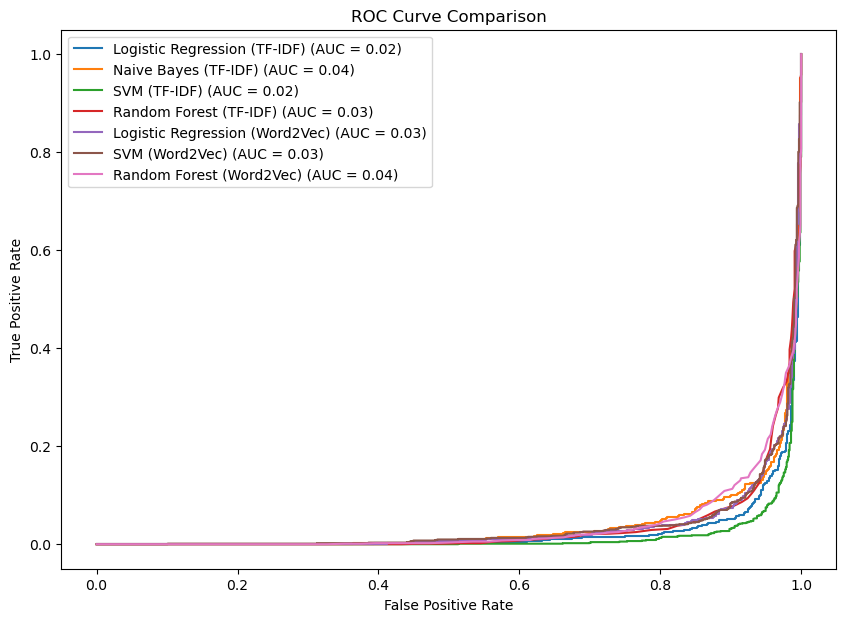

In [26]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(fpr, tpr, roc_auc, label):
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 7))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(tfidf_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs, pos_label='FAKE')
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc, f'{name} (TF-IDF)')

for name, model in w2v_models.items():
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(w2v_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs, pos_label='FAKE')
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc, f'{name} (Word2Vec)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Hyperparameter tuning for logistic regression model

In [27]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(tfidf_train, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 10, 'penalty': 'l2'}


In [28]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with the best parameters
best_logistic_model = LogisticRegression(C=10, penalty='l2', max_iter=1000)

# Train the model with TF-IDF features
best_logistic_model.fit(tfidf_train, y_train)

# Evaluate the model
tfidf_preds = best_logistic_model.predict(tfidf_test)
tfidf_probas = best_logistic_model.predict_proba(tfidf_test)[:, 1]

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, tfidf_preds)
precision = precision_score(y_test, tfidf_preds, pos_label='FAKE')
recall = recall_score(y_test, tfidf_preds, pos_label='FAKE')
f1 = f1_score(y_test, tfidf_preds, pos_label='FAKE')
roc_auc = roc_auc_score(y_test, tfidf_probas)

print("Logistic Regression with TF-IDF (Optimized) Results:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")


Logistic Regression with TF-IDF (Optimized) Results:
Accuracy: 0.941
Precision: 0.923
Recall: 0.958
F1 Score: 0.940
ROC AUC: 0.983


In [29]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for TF-IDF model
cm_tfidf = confusion_matrix(y_test, tfidf_preds, labels=['FAKE', 'REAL'])
print("Confusion Matrix for TF-IDF:")
print(cm_tfidf)


Confusion Matrix for TF-IDF:
[[890  39]
 [ 74 898]]


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize and tune Logistic Regression model
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2']
}

grid_search_w2v = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search_w2v.fit(w2v_train, y_train)

print("Best parameters for Logistic Regression with Word2Vec:", grid_search_w2v.best_params_)


Best parameters for Logistic Regression with Word2Vec: {'C': 0.1, 'penalty': 'l2'}


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize Logistic Regression with the best parameters
best_logistic_w2v_model = LogisticRegression(C=0.1, penalty='l2', max_iter=1000)

# Train the model with Word2Vec features
best_logistic_w2v_model.fit(w2v_train, y_train)

# Evaluate the model
w2v_preds = best_logistic_w2v_model.predict(w2v_test)
w2v_probas = best_logistic_w2v_model.predict_proba(w2v_test)[:, 1]

# Calculate metrics
accuracy_w2v = accuracy_score(y_test, w2v_preds)
precision_w2v = precision_score(y_test, w2v_preds, pos_label='FAKE')
recall_w2v = recall_score(y_test, w2v_preds, pos_label='FAKE')
f1_w2v = f1_score(y_test, w2v_preds, pos_label='FAKE')
roc_auc_w2v = roc_auc_score(y_test, w2v_probas)

print("Logistic Regression with Word2Vec (Optimized) Results:")
print(f"Accuracy: {accuracy_w2v:.3f}")
print(f"Precision: {precision_w2v:.3f}")
print(f"Recall: {recall_w2v:.3f}")
print(f"F1 Score: {f1_w2v:.3f}")
print(f"ROC AUC: {roc_auc_w2v:.3f}")


Logistic Regression with Word2Vec (Optimized) Results:
Accuracy: 0.910
Precision: 0.917
Recall: 0.896
F1 Score: 0.906
ROC AUC: 0.967


In [32]:
# Generate confusion matrix for Word2Vec model
cm_w2v = confusion_matrix(y_test, w2v_preds, labels=['FAKE', 'REAL'])
print("Confusion Matrix for Word2Vec:")
print(cm_w2v)


Confusion Matrix for Word2Vec:
[[832  97]
 [ 75 897]]


Hyperparameter tuning for SVM

In [33]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient (only for 'rbf' kernel)
}


TF-IDF

In [34]:
# Initialize the SVM model
svm = SVC()

# Initialize GridSearchCV
grid_search_tf_idf = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit GridSearchCV on the TF-IDF training data
grid_search_tf_idf.fit(tfidf_train, y_train)

# Print the best parameters and score
print("Best parameters for SVM with TF-IDF:", grid_search_tf_idf.best_params_)
print("Best score for SVM with TF-IDF:", grid_search_tf_idf.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  23.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  24.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  24.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  21.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  21.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  25.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  28.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  30.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  28.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  29.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  23.4s
[CV] END ...................C=0.1, gamma=auto, k

Word2vec

In [35]:
# Initialize GridSearchCV for Word2Vec
grid_search_w2v = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit GridSearchCV on the Word2Vec training data
grid_search_w2v.fit(w2v_train, y_train)

# Print the best parameters and score
print("Best parameters for SVM with Word2Vec:", grid_search_w2v.best_params_)
print("Best score for SVM with Word2Vec:", grid_search_w2v.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, k

In [36]:
# Predict and evaluate for TF-IDF
best_svm_tf_idf = grid_search_tf_idf.best_estimator_
pred_tf_idf = best_svm_tf_idf.predict(tfidf_test)
print("TF-IDF SVM Performance:")
print("Accuracy:", accuracy_score(y_test, pred_tf_idf))
print("Precision:", precision_score(y_test, pred_tf_idf, pos_label='FAKE'))
print("Recall:", recall_score(y_test, pred_tf_idf, pos_label='FAKE'))
print("F1 Score:", f1_score(y_test, pred_tf_idf, pos_label='FAKE'))
print("ROC AUC:", roc_auc_score(y_test, best_svm_tf_idf.decision_function(tfidf_test)))

# Predict and evaluate for Word2Vec
best_svm_w2v = grid_search_w2v.best_estimator_
pred_w2v = best_svm_w2v.predict(w2v_test)
print("Word2Vec SVM Performance:")
print("Accuracy:", accuracy_score(y_test, pred_w2v))
print("Precision:", precision_score(y_test, pred_w2v, pos_label='FAKE'))
print("Recall:", recall_score(y_test, pred_w2v, pos_label='FAKE'))
print("F1 Score:", f1_score(y_test, pred_w2v, pos_label='FAKE'))
print("ROC AUC:", roc_auc_score(y_test, best_svm_w2v.decision_function(w2v_test)))


TF-IDF SVM Performance:
Accuracy: 0.9384534455549711
Precision: 0.921161825726141
Recall: 0.9558665231431647
F1 Score: 0.9381933438985738
ROC AUC: 0.9837993417409755
Word2Vec SVM Performance:
Accuracy: 0.9221462388216728
Precision: 0.926775956284153
Recall: 0.9128094725511302
F1 Score: 0.9197396963123643
ROC AUC: 0.9785988296632957


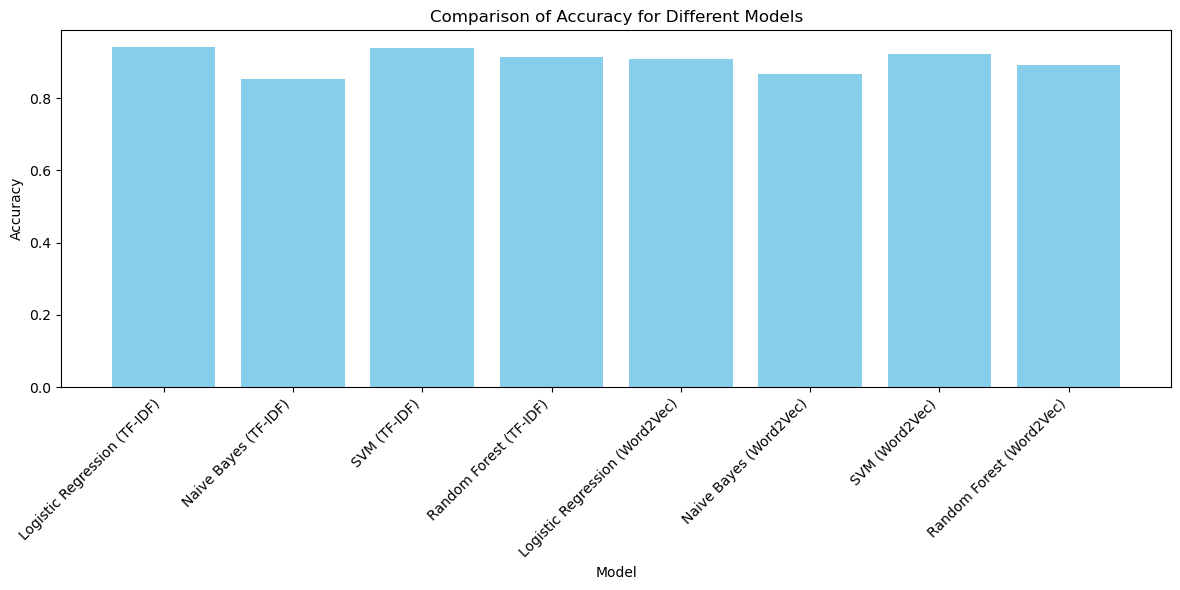

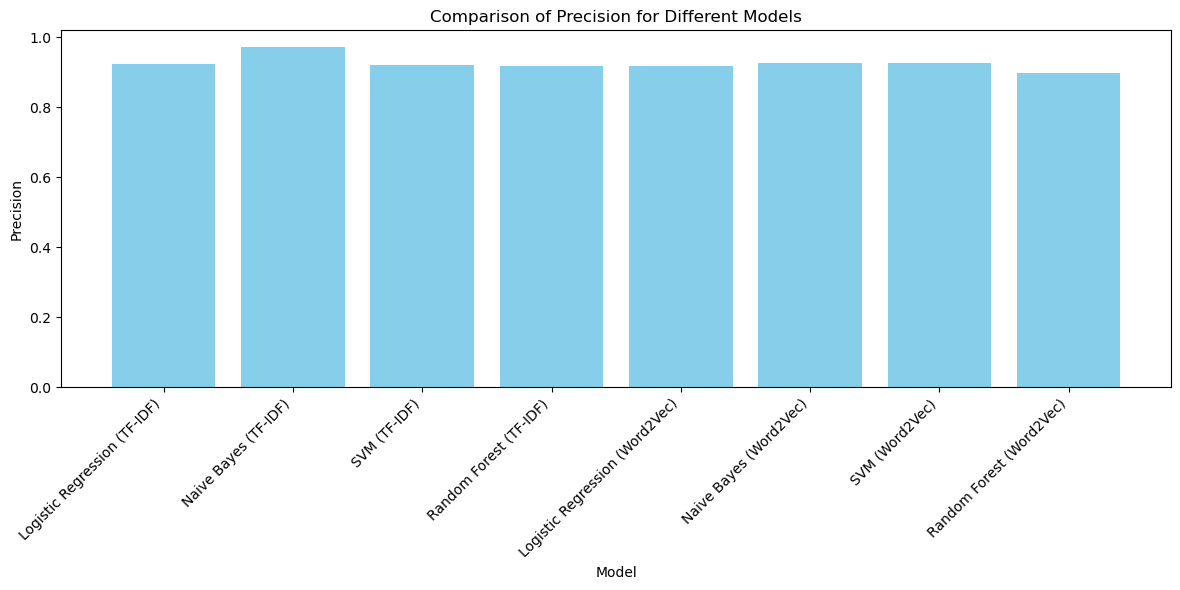

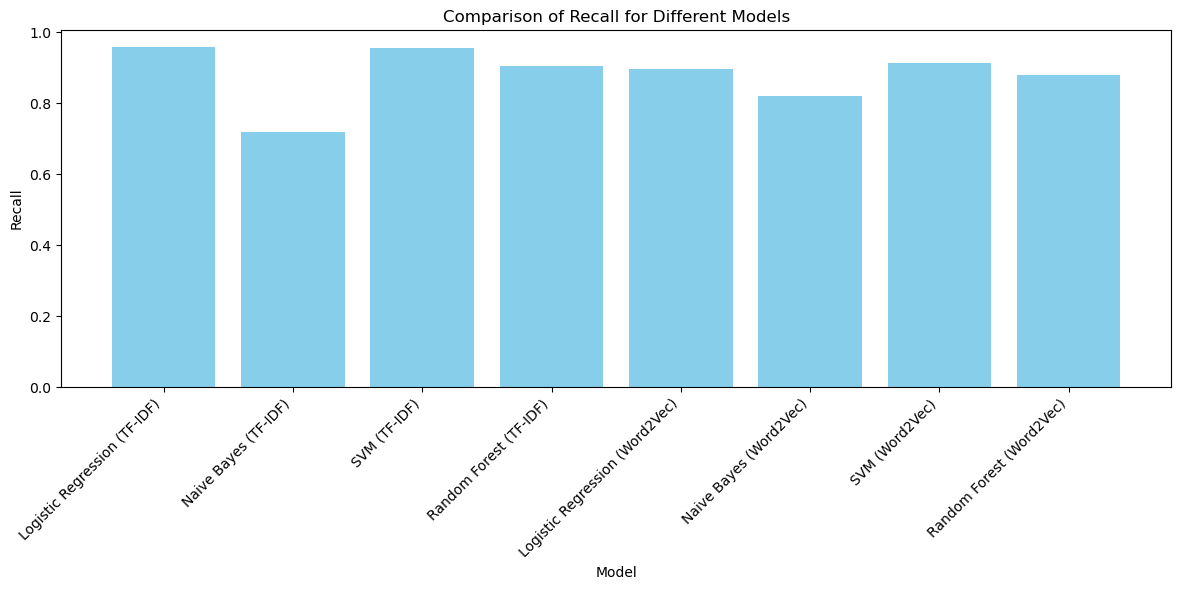

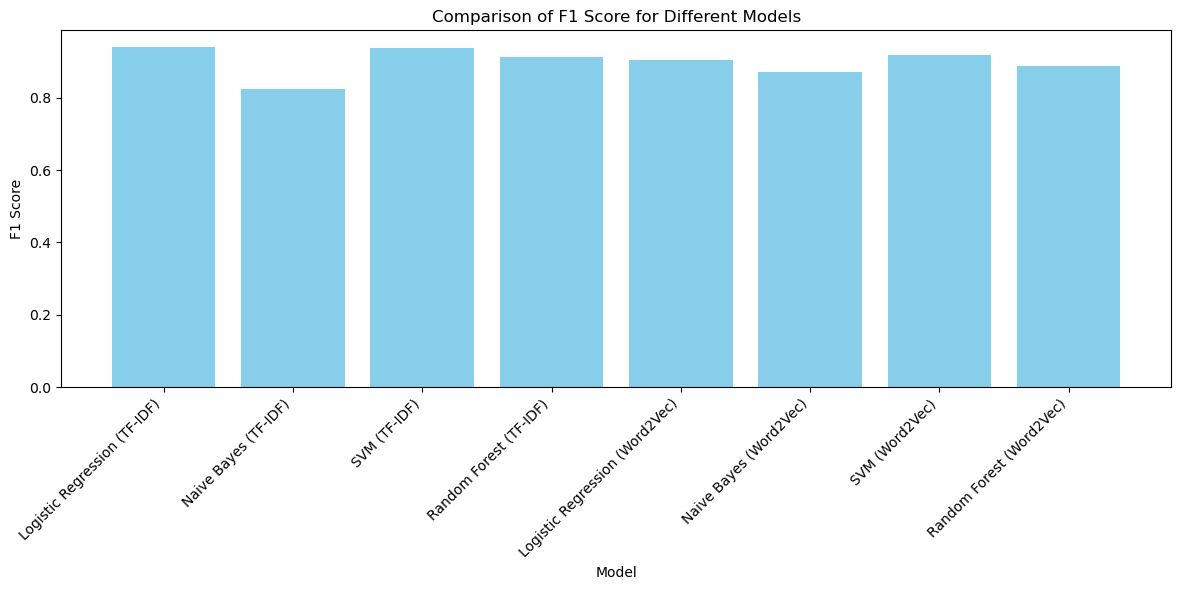

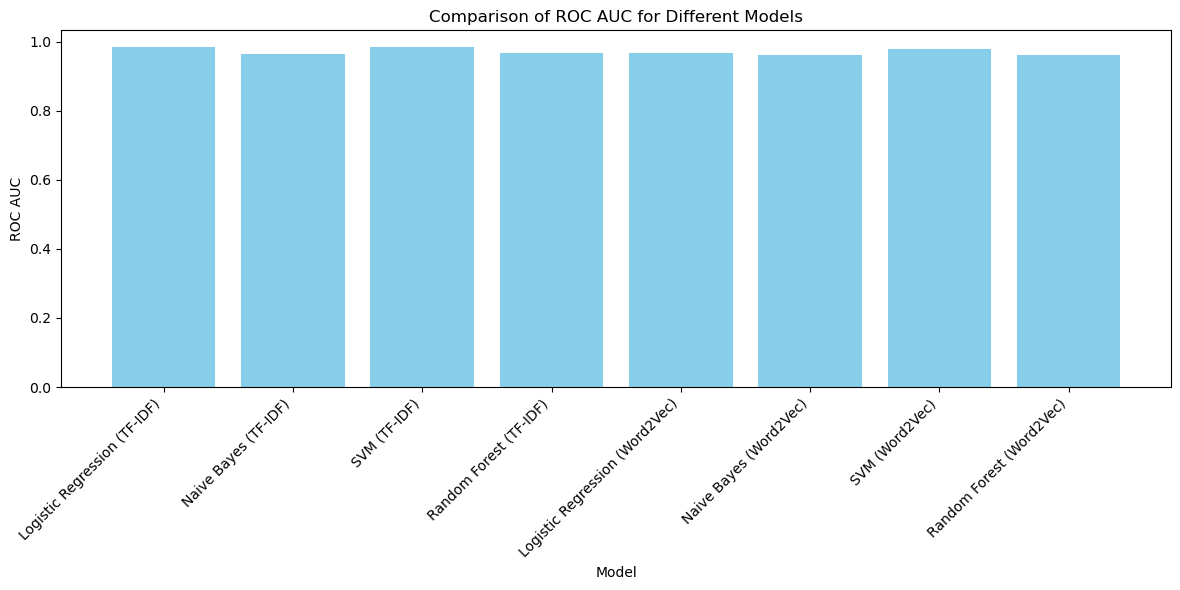

In [40]:
# Updated results
results = {
    'Model': ['Logistic Regression (TF-IDF)', 'Naive Bayes (TF-IDF)', 'SVM (TF-IDF)', 'Random Forest (TF-IDF)',
              'Logistic Regression (Word2Vec)', 'Naive Bayes (Word2Vec)', 'SVM (Word2Vec)', 'Random Forest (Word2Vec)'],
    'Accuracy': [0.941, 0.852, 0.938, 0.915, 0.910, 0.868, 0.922, 0.893],
    'Precision': [0.923, 0.971, 0.921, 0.919, 0.917, 0.927, 0.926, 0.899],
    'Recall': [0.958, 0.719, 0.956, 0.906, 0.896, 0.821, 0.913, 0.879],
    'F1 Score': [0.940, 0.826, 0.938, 0.913, 0.906, 0.873, 0.920, 0.889],
    'ROC AUC': [0.984, 0.964, 0.984, 0.967, 0.967, 0.963, 0.979, 0.962]
}

df_results = pd.DataFrame(results)

# Plot each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    plt.bar(df_results['Model'], df_results[metric], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Different Models')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()